# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.374411
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.815634 analytic: -3.815634, relative error: 8.097283e-09
numerical: 0.469820 analytic: 0.469820, relative error: 9.689146e-08
numerical: -1.731075 analytic: -1.731075, relative error: 1.749493e-09
numerical: -1.789063 analytic: -1.789063, relative error: 3.985617e-08
numerical: 0.353322 analytic: 0.353322, relative error: 1.109299e-08
numerical: -0.844013 analytic: -0.844013, relative error: 2.262629e-08
numerical: -1.006219 analytic: -1.006219, relative error: 5.323245e-09
numerical: 1.902352 analytic: 1.902352, relative error: 2.852993e-08
numerical: 1.686404 analytic: 1.686404, relative error: 2.899679e-08
numerical: 0.181447 analytic: 0.181447, relative error: 2.309380e-07
numerical: 2.092324 analytic: 2.092324, relative error: 1.139584e-08
numerical: 1.249302 analytic: 1.249302, relative error: 2.293209e-08
numerical: -0.953843 analytic: -0.953843, relative error: 3.691996e-10
numerical: -1.028001 analytic: -1.028001, relative error: 9.202633e-08
numerical: 3.450967 

In [32]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.374411e+00 computed in 0.080654s
(500, 10)
vectorized loss: 2.374411e+00 computed in 0.002453s
Loss difference: 0.000000
Gradient difference: 0.000000


In [40]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-8, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_iters = 10
for it in range(num_iters):
    for jt in range(num_iters):
        softmax = Softmax()
        learning_rate = learning_rates[0] + it * ((learning_rates[1] - learning_rates[0]) / num_iters)
        reg = regularization_strengths[0] 
            + jt * ((regularization_strengths[1] - regularization_strengths[0])/ num_iters)
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                              num_iters=1500, verbose=False)
        
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.155592 val accuracy: 0.136000
lr 1.000000e-08 reg 2.625000e+04 train accuracy: 0.155898 val accuracy: 0.156000
lr 1.000000e-08 reg 2.750000e+04 train accuracy: 0.163286 val accuracy: 0.165000
lr 1.000000e-08 reg 2.875000e+04 train accuracy: 0.157694 val accuracy: 0.168000
lr 1.000000e-08 reg 3.000000e+04 train accuracy: 0.173184 val accuracy: 0.184000
lr 1.000000e-08 reg 3.125000e+04 train accuracy: 0.161020 val accuracy: 0.157000
lr 1.000000e-08 reg 3.250000e+04 train accuracy: 0.161143 val accuracy: 0.170000
lr 1.000000e-08 reg 3.375000e+04 train accuracy: 0.173224 val accuracy: 0.167000
lr 1.000000e-08 reg 3.500000e+04 train accuracy: 0.158286 val accuracy: 0.149000
lr 1.000000e-08 reg 3.625000e+04 train accuracy: 0.159714 val accuracy: 0.176000
lr 1.000000e-08 reg 3.750000e+04 train accuracy: 0.147837 val accuracy: 0.125000
lr 1.000000e-08 reg 3.875000e+04 train accuracy: 0.158469 val accuracy: 0.147000
lr 1.000000e-08 reg 4.000000

lr 1.325000e-07 reg 2.750000e+04 train accuracy: 0.262184 val accuracy: 0.276000
lr 1.325000e-07 reg 2.875000e+04 train accuracy: 0.264898 val accuracy: 0.266000
lr 1.325000e-07 reg 3.000000e+04 train accuracy: 0.260265 val accuracy: 0.246000
lr 1.325000e-07 reg 3.125000e+04 train accuracy: 0.259245 val accuracy: 0.282000
lr 1.325000e-07 reg 3.250000e+04 train accuracy: 0.256082 val accuracy: 0.281000
lr 1.325000e-07 reg 3.375000e+04 train accuracy: 0.259082 val accuracy: 0.275000
lr 1.325000e-07 reg 3.500000e+04 train accuracy: 0.266429 val accuracy: 0.279000
lr 1.325000e-07 reg 3.625000e+04 train accuracy: 0.270510 val accuracy: 0.259000
lr 1.325000e-07 reg 3.750000e+04 train accuracy: 0.261612 val accuracy: 0.242000
lr 1.325000e-07 reg 3.875000e+04 train accuracy: 0.259143 val accuracy: 0.266000
lr 1.325000e-07 reg 4.000000e+04 train accuracy: 0.263408 val accuracy: 0.261000
lr 1.325000e-07 reg 4.125000e+04 train accuracy: 0.257245 val accuracy: 0.264000
lr 1.325000e-07 reg 4.250000

lr 2.550000e-07 reg 3.000000e+04 train accuracy: 0.289653 val accuracy: 0.305000
lr 2.550000e-07 reg 3.125000e+04 train accuracy: 0.284429 val accuracy: 0.286000
lr 2.550000e-07 reg 3.250000e+04 train accuracy: 0.288878 val accuracy: 0.300000
lr 2.550000e-07 reg 3.375000e+04 train accuracy: 0.286980 val accuracy: 0.279000
lr 2.550000e-07 reg 3.500000e+04 train accuracy: 0.281510 val accuracy: 0.293000
lr 2.550000e-07 reg 3.625000e+04 train accuracy: 0.288490 val accuracy: 0.265000
lr 2.550000e-07 reg 3.750000e+04 train accuracy: 0.285388 val accuracy: 0.280000
lr 2.550000e-07 reg 3.875000e+04 train accuracy: 0.288878 val accuracy: 0.296000
lr 2.550000e-07 reg 4.000000e+04 train accuracy: 0.289510 val accuracy: 0.272000
lr 2.550000e-07 reg 4.125000e+04 train accuracy: 0.288082 val accuracy: 0.278000
lr 2.550000e-07 reg 4.250000e+04 train accuracy: 0.283653 val accuracy: 0.279000
lr 2.550000e-07 reg 4.375000e+04 train accuracy: 0.292286 val accuracy: 0.297000
lr 2.550000e-07 reg 4.500000

lr 3.775000e-07 reg 3.250000e+04 train accuracy: 0.302327 val accuracy: 0.336000
lr 3.775000e-07 reg 3.375000e+04 train accuracy: 0.307837 val accuracy: 0.307000
lr 3.775000e-07 reg 3.500000e+04 train accuracy: 0.308796 val accuracy: 0.312000
lr 3.775000e-07 reg 3.625000e+04 train accuracy: 0.302694 val accuracy: 0.310000
lr 3.775000e-07 reg 3.750000e+04 train accuracy: 0.306408 val accuracy: 0.310000
lr 3.775000e-07 reg 3.875000e+04 train accuracy: 0.301163 val accuracy: 0.286000
lr 3.775000e-07 reg 4.000000e+04 train accuracy: 0.305204 val accuracy: 0.323000
lr 3.775000e-07 reg 4.125000e+04 train accuracy: 0.304878 val accuracy: 0.318000
lr 3.775000e-07 reg 4.250000e+04 train accuracy: 0.300551 val accuracy: 0.289000
lr 3.775000e-07 reg 4.375000e+04 train accuracy: 0.309143 val accuracy: 0.319000
lr 3.775000e-07 reg 4.500000e+04 train accuracy: 0.305612 val accuracy: 0.294000
lr 3.775000e-07 reg 4.625000e+04 train accuracy: 0.301184 val accuracy: 0.308000
lr 3.775000e-07 reg 4.750000

In [41]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.292000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: We have accounted for numerical instability for Softmax because the scores of some points might be very large and when we do an exp on that number, it tends to go to infinity. In case of SVM, the loss remains unchanged because its a max function of difference of scores. But in case of Softmax, if the score is too large, loss changes by a lot because there is exponential function in the loss.

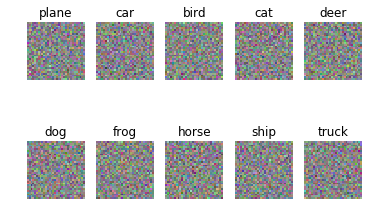

In [42]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])